In [2]:
import zipfile
import pandas as pd

zip_path = "metadata.csv.zip"

with zipfile.ZipFile(zip_path, "r") as z:
    with z.open("metadata.csv") as f:
        df = pd.read_csv(f, low_memory=False)

print("Shape:", df.shape)
print(df.head())

Shape: (1056660, 19)
   cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59

In [5]:
df_small = df.sample(n=10000, random_state=42)
print(df_small.shape)


(10000, 19)


In [7]:
print(df_small.head())


        cord_uid                                       sha  source_x  \
17948   ak20jg32  42a61efa32fae8fb14d1c8c1a8bc528c59e1583a       PMC   
915932  d27cnei3                                       NaN  PMC; WHO   
456857  7fo988o7                                       NaN       WHO   
176672  vcz81w3o                                       NaN   Medline   
40038   3ewr26np                                       NaN       PMC   

                                                    title  \
17948   Development and Internal Validation of a Novel...   
915932  mRNA-1273: Acute disseminated encephalomyeliti...   
456857  The Joint Commission should reconsider its pos...   
176672  Flattening the Curve of Prostate Cancer Progre...   
40038        Vincristine: Various toxicities: case report   

                                 doi       pmcid pubmed_id license  \
17948      10.3389/fpsyt.2021.593710  PMC8172985  34093252   cc-by   
915932    10.1007/s40278-021-06200-0  PMC8617002       NaN  

In [8]:
important_cols = ["title", "abstract", "publish_time", "authors", "journal"]
print(df_small[important_cols].isnull().sum())


title              2
abstract        2221
publish_time      16
authors          210
journal          880
dtype: int64


In [9]:
print(df_small.describe())


       mag_id         s2_id
count     0.0  9.229000e+03
mean      NaN  2.173709e+08
std       NaN  5.343835e+07
min       NaN  7.688600e+04
25%       NaN  2.210791e+08
50%       NaN  2.321081e+08
75%       NaN  2.373652e+08
max       NaN  2.491218e+08


In [12]:

missing_counts = df_small.isnull().sum().sort_values(ascending=False)
print(missing_counts)


mag_id              10000
arxiv_id             9858
pmc_json_files       7001
pdf_json_files       6457
sha                  6457
pmcid                6309
who_covidence_id     5508
pubmed_id            5305
doi                  3703
url                  3429
abstract             2221
journal               880
s2_id                 771
authors               210
publish_time           16
title                   2
license                 0
source_x                0
cord_uid                0
dtype: int64


In [15]:
df_clean = df_small.drop(columns=["mag_id", "arxiv_id"])


In [16]:
# Drop rows missing title or publish_time
df_clean = df_clean.dropna(subset=["title", "publish_time"])

# Fill missing authors and journal with "Unknown"
df_clean["authors"] = df_clean["authors"].fillna("Unknown")
df_clean["journal"] = df_clean["journal"].fillna("Unknown")


In [17]:
# 1. Drop columns with nearly all missing
df_clean = df_small.drop(columns=["mag_id", "arxiv_id"])

# 2. Drop rows missing critical fields
df_clean = df_clean.dropna(subset=["title", "publish_time"])

# 3. Fill missing authors and journal with "Unknown"
df_clean["authors"] = df_clean["authors"].fillna("Unknown")
df_clean["journal"] = df_clean["journal"].fillna("Unknown")

# 4. (Optional) If you want a text-analysis-ready version, drop rows missing abstract
df_text = df_clean.dropna(subset=["abstract"])

print("Cleaned dataset shape:", df_clean.shape)
print("Text-ready dataset shape:", df_text.shape)


Cleaned dataset shape: (9982, 17)
Text-ready dataset shape: (7764, 17)


In [18]:
import pandas as pd

# Start from the cleaned dataset
df_prep = df_clean.copy()

# 1. Convert publish_time to datetime
df_prep["publish_time"] = pd.to_datetime(df_prep["publish_time"], errors="coerce")

# 2. Extract publication year
df_prep["publish_year"] = df_prep["publish_time"].dt.year

# 3. Abstract word count (use text-ready dataset for this)
df_prep["abstract_word_count"] = df_prep["abstract"].fillna("").apply(lambda x: len(x.split()))

# 4. Title word count (optional, useful for quick checks)
df_prep["title_word_count"] = df_prep["title"].fillna("").apply(lambda x: len(x.split()))

# Preview prepared dataset
print(df_prep[["publish_time", "publish_year", "abstract_word_count", "title_word_count"]].head())


       publish_time  publish_year  abstract_word_count  title_word_count
17948    2021-05-20        2021.0                  198                23
915932   2021-11-27        2021.0                    0                 6
456857          NaT           NaN                    0                13
176672   2020-07-15        2020.0                    0                12
40038    2016-06-25        2016.0                    0                 5


In [19]:
import pandas as pd
from collections import Counter
import re

# 1. Count papers by publication year
papers_by_year = df_prep["publish_year"].value_counts().sort_index()

# 2. Top journals publishing COVID-19 research
top_journals = df_prep["journal"].value_counts().head(10)

# 3. Most frequent words in titles
def tokenize(text):
    # Lowercase, keep only words (remove numbers, punctuation)
    words = re.findall(r'\b[a-zA-Z]{3,}\b', str(text).lower())
    return words

# Apply tokenization to titles
all_title_words = df_prep["title"].dropna().apply(tokenize)

# Flatten list of words
flat_words = [word for words in all_title_words for word in words]

# Count frequencies
word_freq = Counter(flat_words).most_common(20)

# Display results
print("=== Papers by Year ===")
print(papers_by_year)

print("\n=== Top Journals ===")
print(top_journals)

print("\n=== Most Frequent Title Words ===")
print(word_freq)


=== Papers by Year ===
publish_year
1985.0       1
1987.0       1
1988.0       1
1990.0       1
1991.0       1
1993.0       3
1995.0       1
1997.0       1
1998.0       2
1999.0       4
2000.0       6
2001.0       1
2002.0       5
2003.0       4
2004.0      21
2005.0      16
2006.0       9
2007.0      21
2008.0      22
2009.0      26
2010.0      17
2011.0      26
2012.0      21
2013.0      23
2014.0      28
2015.0      34
2016.0      29
2017.0      34
2018.0      41
2019.0      43
2020.0    1637
2021.0    2128
2022.0     763
Name: count, dtype: int64

=== Top Journals ===
journal
Unknown                            867
bioRxiv                             98
PLoS One                            88
Int J Environ Res Public Health     76
Sci Rep                             54
BMJ                                 54
Reactions Weekly                    41
Front Immunol                       37
Front Psychol                       36
JAMA                                35
Name: count, dtype: int

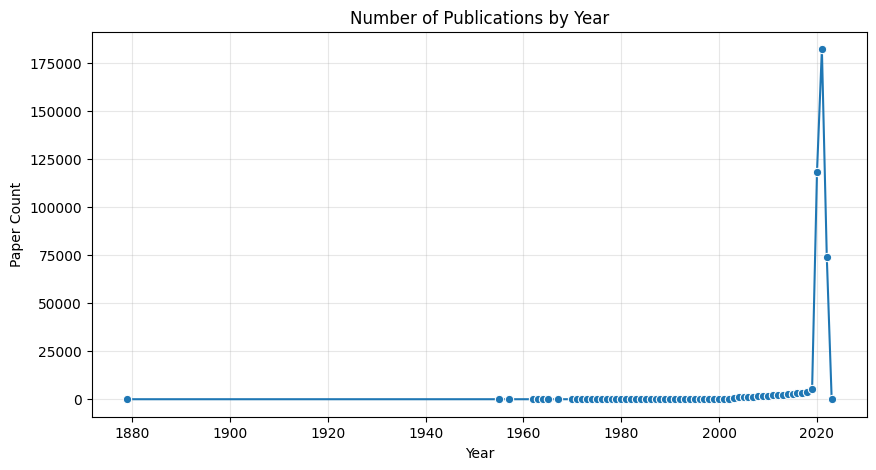

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


# --- 1. Number of publications over time ---
pubs_per_year = text_ready.groupby("publish_year").size()

plt.figure(figsize=(10,5))
sns.lineplot(x=pubs_per_year.index, y=pubs_per_year.values, marker="o")
plt.title("Number of Publications by Year")
plt.xlabel("Year")
plt.ylabel("Paper Count")
plt.grid(True, alpha=0.3)
plt.show()


C:\Users\DIANA\AppData\Local\Temp\ipykernel_8588\2336384928.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_journals.values, y=top_journals.index, palette="viridis")


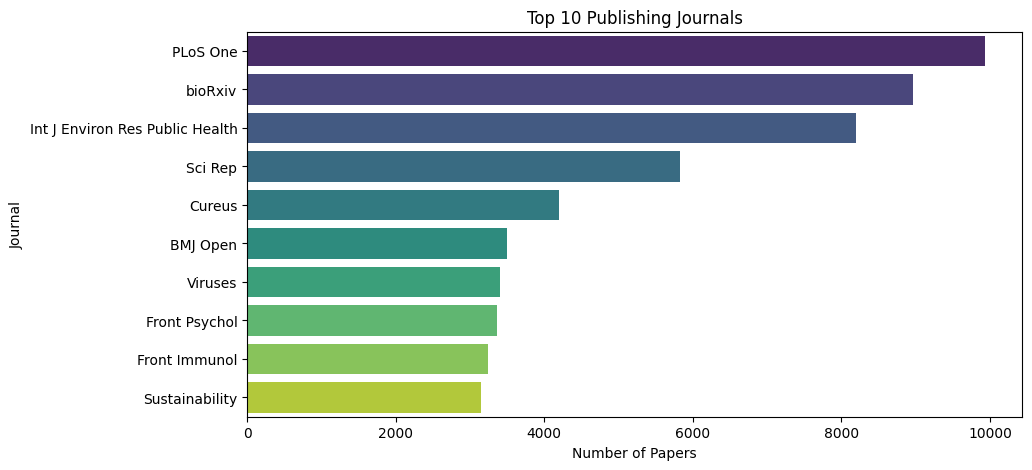

In [30]:
# --- 2. Top publishing journals ---
top_journals = text_ready['journal'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_journals.values, y=top_journals.index, palette="viridis")
plt.title("Top 10 Publishing Journals")
plt.xlabel("Number of Papers")
plt.ylabel("Journal")
plt.show()

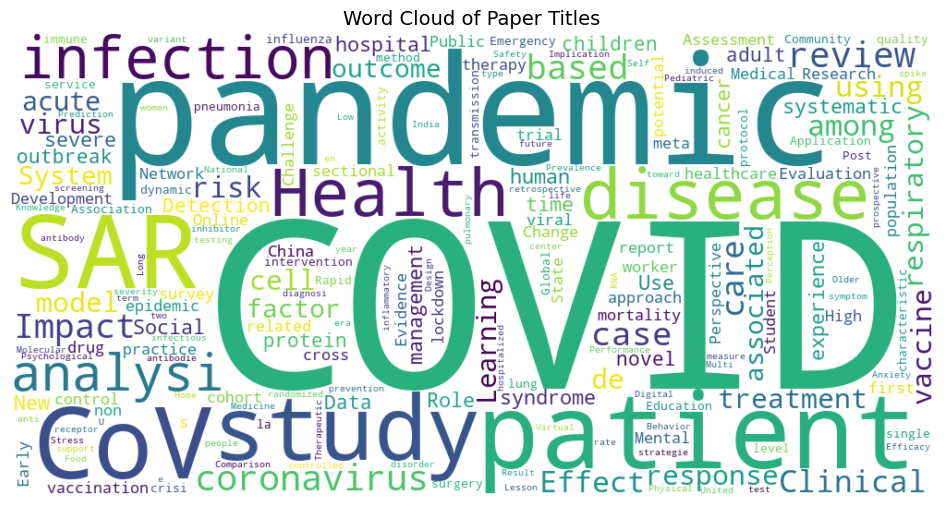

In [33]:
from wordcloud import WordCloud
# --- 3. Word cloud of paper titles ---
all_titles = " ".join(text_ready['title'].dropna().astype(str))
wordcloud = WordCloud(width=1000, height=500, background_color="white",
                      collocations=False).generate(all_titles)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Paper Titles", fontsize=14)
plt.show()

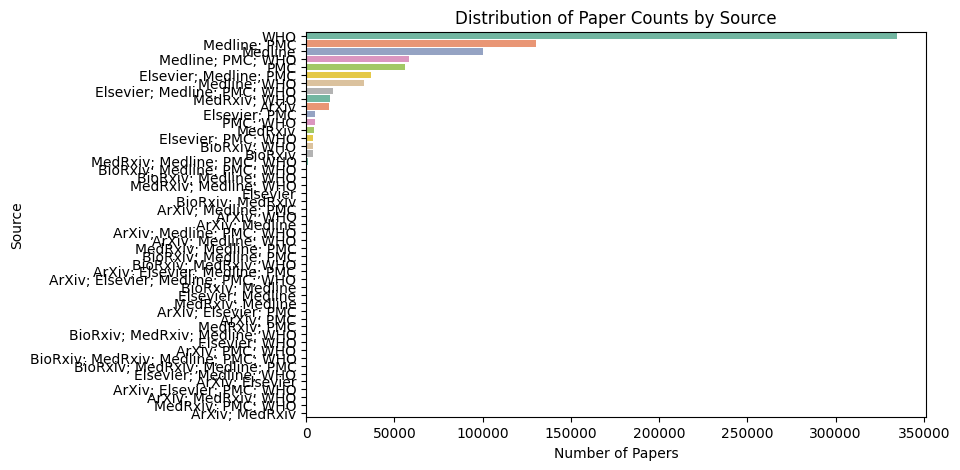

In [34]:
# --- 4. Distribution by source ---
source_counts = text_ready['source_x'].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=source_counts.values,
            y=source_counts.index,
            hue=source_counts.index,
            dodge=False, legend=False,
            palette="Set2")
plt.title("Distribution of Paper Counts by Source")
plt.xlabel("Number of Papers")
plt.ylabel("Source")
plt.show()

In [37]:
cleaned_df.to_csv("metadata_cleaned.csv", index=False)


In [ ]:
import os
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Loading Function ---
@st.cache_data
def load_data():
    if os.path.exists("metadata_cleaned.csv"):
        # Load cleaned dataset if available
        df = pd.read_csv("metadata_cleaned.csv")
    else:
        # Fall back to raw metadata.csv if cleaned version missing
        raw_path = "metadata.csv"  # adjust if your raw file has a different name
        if not os.path.exists(raw_path):
            st.error("Neither 'metadata_cleaned.csv' nor 'metadata.csv' found! Please upload your dataset.")
            return pd.DataFrame()

        df = pd.read_csv(raw_path, low_memory=False)

        # Minimal cleaning
        df = df.dropna(subset=["title", "abstract"]).copy()
        df["publish_time"] = pd.to_datetime(df["publish_time"], errors="coerce")
        df["publish_year"] = df["publish_time"].dt.year
        df["abstract_word_count"] = df["abstract"].fillna("").apply(lambda x: len(x.split()))
        df["title_word_count"] = df["title"].fillna("").apply(lambda x: len(x.split()))

        # Save for next run
        df.to_csv("metadata_cleaned.csv", index=False)

    return df


# --- 2. Streamlit Layout ---
st.title("COVID-19 Research Papers Explorer 📊")
st.write("Explore publication trends, top journals, and frequent keywords in COVID-19 research papers.")

df = load_data()

if df.empty:
    st.stop()

# --- 3. Interactive Widgets ---
years = st.slider("Select Publication Year Range", 
                  int(df["publish_year"].min()), 
                  int(df["publish_year"].max()), 
                  (2020, 2021))

subset = df[(df["publish_year"] >= years[0]) & (df["publish_year"] <= years[1])]

# --- 4. Visualizations ---
st.subheader("Number of Publications Over Time")
pubs_per_year = df.groupby("publish_year").size()
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=pubs_per_year.index, y=pubs_per_year.values, marker="o", ax=ax)
st.pyplot(fig)

st.subheader("Top Journals")
top_journals = df["journal"].value_counts().head(10)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=top_journals.values, y=top_journals.index, ax=ax)
st.pyplot(fig)

st.subheader("Sample Data")
st.dataframe(subset.head(10))
